In [181]:
!pip install isoweek
!pip install chart_studio
!pip install ipykernel


In [182]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import pandas as pd
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML
import os
import isoweek
#import holoviews as hv
import matplotlib.pyplot as plt
import seaborn as sns
#from holoviews import opts
#hv.extension('bokeh', 'matplotlib')


In [183]:
# read file in
import pandas as pd
import numpy as np
file = 'Datasets\somalia_daily_dataset.csv'
df_daily = pd.read_csv(file, 
                         usecols=['time','rfe','rfe_filled'],
                         parse_dates=['time'], dayfirst=True)
df_daily.head()
#df_daily['time'] = pd.to_datetime(df_daily['time'])

,time,rfe,rfe_filled
0,1983-01-01,-999.0,0.03
1,1983-01-02,-999.0,0.09
2,1983-01-03,-999.0,0.48
3,1983-01-04,-999.0,0.13
4,1983-01-05,-999.0,0.04


In [184]:
# yearweek

def iso_week_generator(yearweek):
    '''
    A function which transforms a year week combo into isoweek date.
    This makes sure we start at every Monday of the week in summing up weekly rainfall.
    '''
    from isoweek import Week
    yw_str = str(yearweek)
    year = yw_str[0:4]
    wk = yw_str[4:6]
    start_d = Week(int(year), int(wk)).monday()
    return start_d


In [185]:
# year, week of year average,

def rainfall(df):
    '''
    a straightforward preprocessing function for the raw input file.
Several time series-based features are being developed for future use.
    '''
    import math
    f = "%Y/%m/%d"
    df['Year'], df['Week'] = df['time'].dt.year, df['time'].dt.isocalendar().week
    df['Week'] = df.apply(lambda x: ''.join(['0', str(x['Week'])] if x['Week'] < 10 else str(x['Week'])),axis=1)
    df['YearWeek'] = df[['Year','Week']].astype(str).apply(''.join,1)
    df['Date'] = df.apply(lambda x: iso_week_generator(x['YearWeek']), axis=1)
    df_fin = df.groupby(['YearWeek','Date'], as_index=False)['rfe_filled'].sum()
    # date into datetime
    df_fin['Date'] = pd.to_datetime(df_fin['Date'], format=f)
    # month, week num, week in month
    df_fin["Month"], df_fin['Month_Name']  = df_fin['Date'].dt.month, df_fin['Date'].dt.strftime('%b')
    df_fin['WeekNum'] = df_fin.apply(lambda x: x['Date'].isocalendar()[1], axis=1)
    df_fin['Quarter'] = df_fin.apply(lambda x: x['Date'].quarter, axis=1)
    df_fin['Day'] = df_fin.apply(lambda x: x['Date'].day, axis=1)
    df_fin['WeekinMonth'] = df_fin.apply(lambda x: math.ceil(pd.to_numeric(x['Day']/7)), axis=1)
    
    return df_fin
     

In [186]:
# pre-process rainfall data
df_som = rainfall(df_daily)


In [187]:
# pretty table

table = ff.create_table(df_som[['YearWeek', 'rfe_filled','Month', 'Month_Name', 'WeekNum', 'Quarter',
       'Day']].head(4))
table
     

In [188]:
# mean rainfall everyweek 

df_som['Mean_weekly_rainfall'] = df_som.groupby(['WeekNum'])['rfe_filled'].transform(np.mean)

df_som.head(4)

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall
0,198301,1983-01-03,0.66,1,Jan,1,1,3,1,0.486383
1,198302,1983-01-10,0.02,1,Jan,2,1,10,2,0.104250
2,198303,1983-01-17,0.00,1,Jan,3,1,17,3,0.139500
3,198304,1983-01-24,0.00,1,Jan,4,1,24,4,0.088000


In [189]:
df_som[14:].head()

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall
14,198315,1983-04-11,6.11,4,Apr,15,2,11,2,19.113590
15,198316,1983-04-18,6.66,4,Apr,16,2,18,3,16.929231
16,198317,1983-04-25,15.96,4,Apr,17,2,25,4,18.496923
17,198318,1983-05-02,14.82,5,May,18,2,2,1,18.171795
18,198319,1983-05-09,3.97,5,May,19,2,9,2,16.349231


In [190]:
# rain season flag
df_som['Rain_Season'] = (df_som['Quarter'] == 2) | (df_som['Quarter'] == 4) 
df_som["Rain_Season"] = df_som["Rain_Season"].astype(int)
df_som[10:].head()

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season
10,198311,1983-03-14,0.01,3,Mar,11,1,14,2,2.261282,0
11,198312,1983-03-21,0.08,3,Mar,12,1,21,3,3.281795,0
12,198313,1983-03-28,1.14,3,Mar,13,1,28,4,10.301026,0
13,198314,1983-04-04,8.14,4,Apr,14,2,4,1,12.858205,1
14,198315,1983-04-11,6.11,4,Apr,15,2,11,2,19.113590,1


In [191]:
print(len(df_som[(df_som['Rain_Season'] == 1)]))

1021


In [192]:
# boolean condition if rain season flag and rainfall < mean weekly rainfall == drought
df_som['Drought'] = (df_som['Rain_Season'] == 1) & (df_som['rfe_filled'] < df_som['Mean_weekly_rainfall']) 
df_som["Drought"] = df_som["Drought"].astype(int)
df_som[10:].head()

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought
10,198311,1983-03-14,0.01,3,Mar,11,1,14,2,2.261282,0,0
11,198312,1983-03-21,0.08,3,Mar,12,1,21,3,3.281795,0,0
12,198313,1983-03-28,1.14,3,Mar,13,1,28,4,10.301026,0,0
13,198314,1983-04-04,8.14,4,Apr,14,2,4,1,12.858205,1,1
14,198315,1983-04-11,6.11,4,Apr,15,2,11,2,19.113590,1,1


In [193]:
df_som.head()

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought
0,198301,1983-01-03,0.66,1,Jan,1,1,3,1,0.486383,0,0
1,198302,1983-01-10,0.02,1,Jan,2,1,10,2,0.104250,0,0
2,198303,1983-01-17,0.00,1,Jan,3,1,17,3,0.139500,0,0
3,198304,1983-01-24,0.00,1,Jan,4,1,24,4,0.088000,0,0
4,198305,1983-01-31,0.35,1,Jan,5,1,31,5,0.070750,0,0


In [194]:
df_som[(df_som['Rain_Season'] == 1) & (df_som['rfe_filled'] < df_som['Mean_weekly_rainfall'])]

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought
13,198314,1983-04-04,8.14,4,Apr,14,2,4,1,12.858205,1,1
14,198315,1983-04-11,6.11,4,Apr,15,2,11,2,19.113590,1,1
15,198316,1983-04-18,6.66,4,Apr,16,2,18,3,16.929231,1,1
16,198317,1983-04-25,15.96,4,Apr,17,2,25,4,18.496923,1,1
17,198318,1983-05-02,14.82,5,May,18,2,2,1,18.171795,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2034,202146,2021-11-15,1.90,11,Nov,46,4,15,3,7.849744,1,1
2036,202148,2021-11-29,1.62,11,Nov,48,4,29,5,5.902051,1,1
2037,202149,2021-12-06,0.21,12,Dec,49,4,6,1,3.092564,1,1
2040,202152,2021-12-27,0.84,12,Dec,52,4,27,4,1.755750,1,1


In [195]:
file1 = 'Datasets\somalia_dataset.csv'

df_monthly = pd.read_csv(file1, 
                         usecols=['time','rfe','rfe_filled'],
                         parse_dates=['time'], dayfirst=True)
df_monthly['Month_Name'] = df_monthly['time'].dt.strftime('%b')
df_monthly['Year'] = df_monthly['time'].dt.year
df_monthly['Mean_monthly_rainfall'] = df_monthly.groupby(['time'])['rfe_filled'].transform(np.mean)
df_monthly['Quarter'] = df_monthly.apply(lambda x: x['time'].quarter, axis=1)
df_monthly['Year_Quarter'] = df_monthly[['Year','Quarter']].astype(str).apply(''.join,1)
df_monthly['Rain_Season'] = (df_monthly['Quarter'] == 2) | (df_monthly['Quarter'] == 4) 
df_monthly["Rain_Season"] = df_monthly["Rain_Season"].astype(int)
df_monthly['Drought'] = (df_monthly['Rain_Season'] == 1) & (df_monthly['rfe'] < df_monthly['Mean_monthly_rainfall']) 
df_monthly["Drought"] = df_monthly["Drought"].astype(int)
df_monthly.head()

,time,rfe,rfe_filled,Month_Name,Year,Mean_monthly_rainfall,Quarter,Year_Quarter,Rain_Season,Drought
0,1983-01-31,-999.00,0.89,Jan,1983,0.89,1,19831,0,0
1,1983-02-28,1.94,1.94,Feb,1983,1.94,1,19831,0,0
2,1983-03-31,0.19,0.19,Mar,1983,0.19,1,19831,0,0
3,1983-04-30,37.98,37.98,Apr,1983,37.98,2,19832,1,0
4,1983-05-31,64.30,64.30,May,1983,64.30,2,19832,1,0


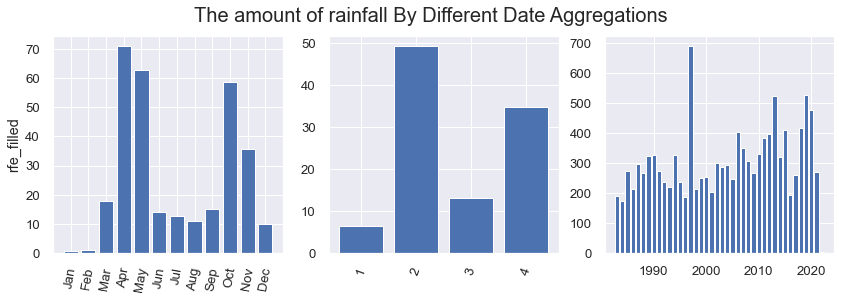

In [196]:
# rainfall amount by different aggregation level
custom_dict = {'Jan': 0, 'Feb': 1, 'Mar': 3, 'Apr':4, 'May':5, 'Jun':6,
               'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12} 

year = df_monthly.groupby('Year').agg({'rfe_filled': 'sum'}).sort_index()
month = df_monthly.groupby('Month_Name').agg({'rfe_filled': 'mean'}).sort_values(by=['Month_Name'], 
                                                                                    key=lambda x: x.map(custom_dict))

quarter = df_monthly.groupby('Quarter').agg({'rfe_filled': 'mean'}).sort_index()

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('The amount of rainfall By Different Date Aggregations', fontsize=20)

ax[0].bar(month.index.values, month['rfe_filled'], label='Monthly')
ax[0].xaxis.set_tick_params(rotation=80)
ax[0].set_ylabel('rfe_filled');

ax[1].bar(quarter.index.values, quarter['rfe_filled'], label='Quarter')
ax[1].xaxis.set_tick_params(rotation=70);

ax[2].bar(year.index.values, year['rfe_filled'], label='Yearly');

In [197]:
df_fin = df_monthly.groupby(['Year_Quarter'], as_index=False)['rfe_filled', 'Mean_monthly_rainfall'].sum()

df_fin.head()

,Year_Quarter,rfe_filled,Mean_monthly_rainfall
0,19831,3.02,3.02
1,19832,117.14,117.14
2,19833,36.75,36.75
3,19834,32.81,32.81
4,19841,0.51,0.51


## AutoCorrelation And Partial AutoCorrelation Function Plot of the rainfall Time Series (rfe_filled) adjusted with respect to 10 lags

Text(0, 0.5, 'Correlation Coefficient')

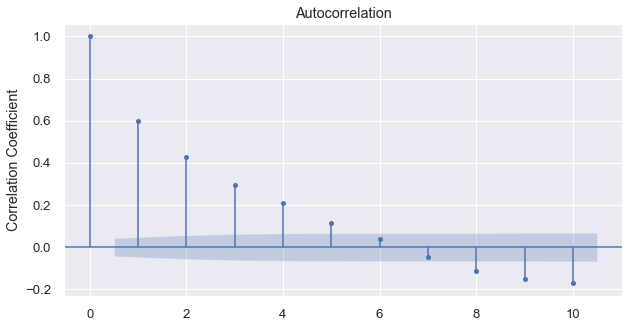

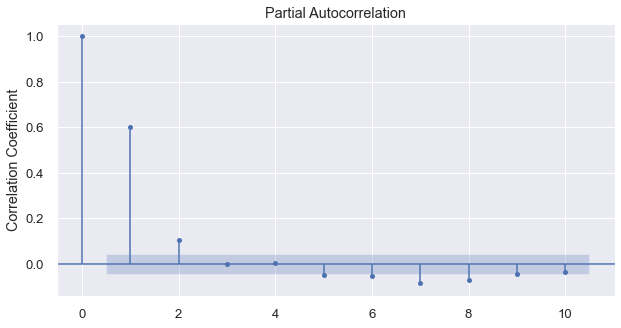

In [198]:
#autocorrelation_plot.py
# inspect lagged values of the past
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_som['rfe_filled'], lags=10, ax=ax)
ax.set_ylabel('Correlation Coefficient');

fig2, ax2 = plt.subplots(figsize=(10, 5))

plot_pacf(df_som['rfe_filled'], lags=10, ax=ax2)
ax2.set_ylabel('Correlation Coefficient')

In [199]:
# create lagged variables

def lagged_features(df):
  '''
  Extract lagged features using Pandas shift function: 1, 2.. 5 weeks.
  '''
  df['Lag_Rainfall_mm_1w'] = df['rfe_filled'].shift(1)
  df['Lag_Rainfall_mm_2w'] = df['rfe_filled'].shift(2)
  df['Lag_Rainfall_mm_3w'] = df['rfe_filled'].shift(3)
  df['Lag_Rainfall_mm_4w'] = df['rfe_filled'].shift(4)
  df['Lag_Rainfall_mm_5w'] = df['rfe_filled'].shift(5)
  df['Lag_Rainfall_mm_6w'] = df['rfe_filled'].shift(6)
  # return
  return df.fillna(0)

In [200]:
df_mod = lagged_features(df_som)

df_mod.head()

,YearWeek,Date,rfe_filled,Month,Month_Name,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought,Lag_Rainfall_mm_1w,Lag_Rainfall_mm_2w,Lag_Rainfall_mm_3w,Lag_Rainfall_mm_4w,Lag_Rainfall_mm_5w,Lag_Rainfall_mm_6w
0,198301,1983-01-03,0.66,1,Jan,1,1,3,1,0.486383,0,0,0.00,0.00,0.00,0.00,0.0,0.0
1,198302,1983-01-10,0.02,1,Jan,2,1,10,2,0.104250,0,0,0.66,0.00,0.00,0.00,0.0,0.0
2,198303,1983-01-17,0.00,1,Jan,3,1,17,3,0.139500,0,0,0.02,0.66,0.00,0.00,0.0,0.0
3,198304,1983-01-24,0.00,1,Jan,4,1,24,4,0.088000,0,0,0.00,0.02,0.66,0.00,0.0,0.0
4,198305,1983-01-31,0.35,1,Jan,5,1,31,5,0.070750,0,0,0.00,0.00,0.02,0.66,0.0,0.0


In [201]:
# create time period variable
df_mod['Time_t'] = df_mod.index + 1

df_mod.drop(columns=['YearWeek','Month_Name'], axis=1,inplace=True)

df_mod.set_index('Date', inplace=True)

df_mod.head()

,rfe_filled,Month,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought,Lag_Rainfall_mm_1w,Lag_Rainfall_mm_2w,Lag_Rainfall_mm_3w,Lag_Rainfall_mm_4w,Lag_Rainfall_mm_5w,Lag_Rainfall_mm_6w,Time_t
Date,,,,,,,,,,,,,,,,
1983-01-03,0.66,1,1,1,3,1,0.486383,0,0,0.00,0.00,0.00,0.00,0.0,0.0,1
1983-01-10,0.02,1,2,1,10,2,0.104250,0,0,0.66,0.00,0.00,0.00,0.0,0.0,2
1983-01-17,0.00,1,3,1,17,3,0.139500,0,0,0.02,0.66,0.00,0.00,0.0,0.0,3
1983-01-24,0.00,1,4,1,24,4,0.088000,0,0,0.00,0.02,0.66,0.00,0.0,0.0,4
1983-01-31,0.35,1,5,1,31,5,0.070750,0,0,0.00,0.00,0.02,0.66,0.0,0.0,5


In [202]:
# rainfall difference between average weekly rainfall

df_mod['Avg_Rainfall_Diff'] = df_mod.apply(lambda x: np.round(x['rfe_filled']-x['Mean_weekly_rainfall'],decimals=2),axis=1)

df_mod.head()

,rfe_filled,Month,WeekNum,Quarter,Day,WeekinMonth,Mean_weekly_rainfall,Rain_Season,Drought,Lag_Rainfall_mm_1w,Lag_Rainfall_mm_2w,Lag_Rainfall_mm_3w,Lag_Rainfall_mm_4w,Lag_Rainfall_mm_5w,Lag_Rainfall_mm_6w,Time_t,Avg_Rainfall_Diff
Date,,,,,,,,,,,,,,,,,
1983-01-03,0.66,1,1,1,3,1,0.486383,0,0,0.00,0.00,0.00,0.00,0.0,0.0,1,0.17
1983-01-10,0.02,1,2,1,10,2,0.104250,0,0,0.66,0.00,0.00,0.00,0.0,0.0,2,-0.08
1983-01-17,0.00,1,3,1,17,3,0.139500,0,0,0.02,0.66,0.00,0.00,0.0,0.0,3,-0.14
1983-01-24,0.00,1,4,1,24,4,0.088000,0,0,0.00,0.02,0.66,0.00,0.0,0.0,4,-0.09
1983-01-31,0.35,1,5,1,31,5,0.070750,0,0,0.00,0.00,0.02,0.66,0.0,0.0,5,0.28


In [203]:
# rearrange columns

cols = ['Time_t','Month', 'WeekNum', 'Quarter', 'Day', 'WeekinMonth', 'rfe_filled', 
       'Mean_weekly_rainfall', 'Avg_Rainfall_Diff', 'Rain_Season', 'Drought', 'Lag_Rainfall_mm_1w',
       'Lag_Rainfall_mm_2w', 'Lag_Rainfall_mm_3w', 'Lag_Rainfall_mm_4w','Lag_Rainfall_mm_5w']

df_mod = df_mod[cols]

df_mod.head()

,Time_t,Month,WeekNum,Quarter,Day,WeekinMonth,rfe_filled,Mean_weekly_rainfall,Avg_Rainfall_Diff,Rain_Season,Drought,Lag_Rainfall_mm_1w,Lag_Rainfall_mm_2w,Lag_Rainfall_mm_3w,Lag_Rainfall_mm_4w,Lag_Rainfall_mm_5w
Date,,,,,,,,,,,,,,,,
1983-01-03,1,1,1,1,3,1,0.66,0.486383,0.17,0,0,0.00,0.00,0.00,0.00,0.0
1983-01-10,2,1,2,1,10,2,0.02,0.104250,-0.08,0,0,0.66,0.00,0.00,0.00,0.0
1983-01-17,3,1,3,1,17,3,0.00,0.139500,-0.14,0,0,0.02,0.66,0.00,0.00,0.0
1983-01-24,4,1,4,1,24,4,0.00,0.088000,-0.09,0,0,0.00,0.02,0.66,0.00,0.0
1983-01-31,5,1,5,1,31,5,0.35,0.070750,0.28,0,0,0.00,0.00,0.02,0.66,0.0


## Calculates the cummulative rainfall estimates for the year quaters

In [204]:
# correlation matrix plot

def corr_heatmap(df):
    '''
    Seaborn Heatmap with mirror removed
    '''
    import seaborn as sns
    sns.set(font_scale=1.0)
    if isinstance(df, pd.DataFrame):
        fig, ax = plt.subplots(figsize=(12,8))
        mask = np.zeros_like(df.corr(), dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True 
        ax = sns.heatmap(df.corr().round(2), mask=mask, ax=ax, cmap='YlGnBu', annot=True, fmt='.2g')
        plt.title('Pearson Correlation Heatmap', fontsize=16)
        plt.xticks(rotation = 80)
        
    else:
        print('pd.DataFrame object needed!')

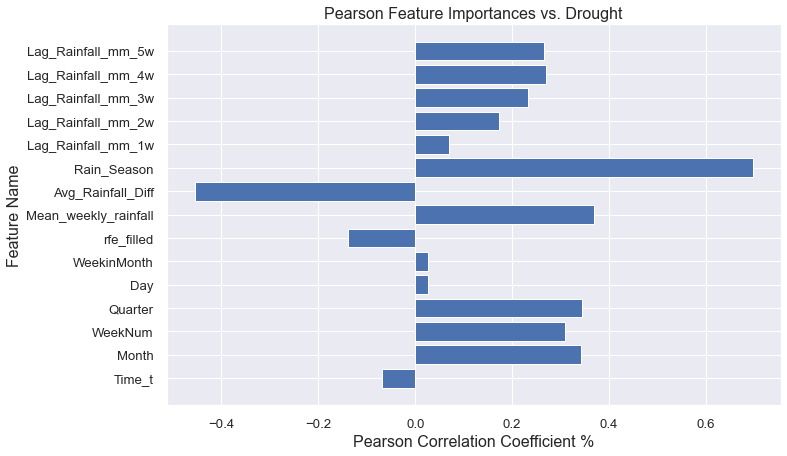

In [205]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation
plt.figure(figsize=(11,7))
sns.set(font_scale=1.2)

# define x, y
X, y = df_mod.drop('Drought', axis=1), df_mod['Drought']

# Create a list of the feature names
features = np.array(X.columns)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

visualizer.fit(X, y)

plt.title('Pearson Feature Importances vs. Drought', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient %', fontsize=16)
plt.ylabel('Feature Name', fontsize=16);

In [206]:
# using uncertain times to see how well drought is predicted in times of peril 
df_mod.dropna(how='any', inplace=True)
X_train = df_mod.loc[:'2015-10-31'].drop(['Drought', 'WeekNum', 'Quarter'], axis=1)
X_test = df_mod.loc['2015-10-31':].drop(['Drought', 'WeekNum', 'Quarter'], axis=1)
y_train = df_mod.loc[:'2015-10-31'][['Drought']]
y_test = df_mod.loc['2015-10-31':][['Drought']]

print(X_train.shape)
print(X_test.shape)

(1718, 13)
(330, 13)


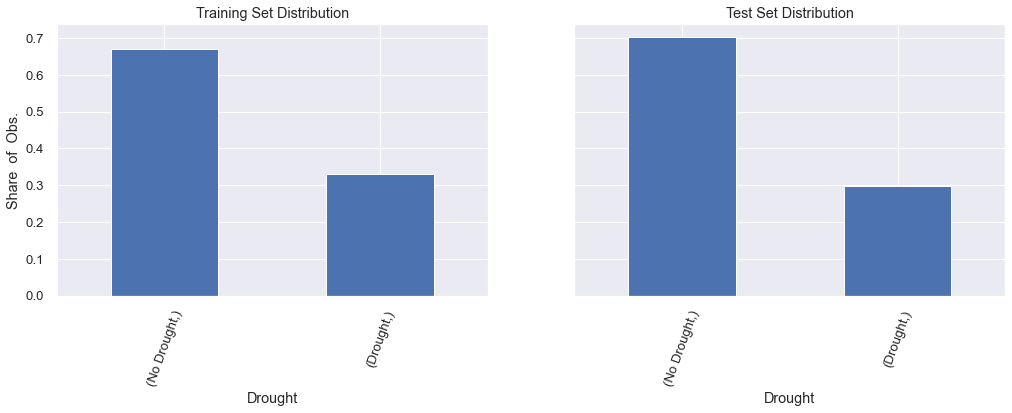

In [207]:
fig, axs = plt.subplots(ncols=2, figsize=(17, 5), sharey=True)
y_train.replace({0:'No Drought', 1: 'Drought'}).value_counts(normalize = True).plot(kind="bar", ax=axs[0])
axs[0].set_title("Training Set Distribution")
axs[0].xaxis.set_tick_params(rotation=70)
axs[0].set_ylabel('Share  of  Obs.')
y_test.replace({0:'No Drought', 1: 'Drought'}).value_counts(normalize=True).plot(kind="bar", ax=axs[1])
axs[1].set_title("Test Set Distribution")
axs[1].xaxis.set_tick_params(rotation=70)
plt.show()

In [208]:
def model_runner_log(m, X_train, X_test, y_train, y_test):
  '''
  A generic function which runs a logistic classification model.
  Outputs key performance metrices for model evaluation.
  '''
  # learn model with train set
  from sklearn.metrics import classification_report
  model_name = 'Logistic Regression'
  m.fit(X_train, y_train)
  y_pred_train, y_pred_test = m.predict(X_train), m.predict(X_test)
  y_prob = m.predict_proba(X_test)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  print("Train_set Accuracy of {a} is {b}%".format(a=model_name, 
                                                   b=np.round(train_accuracy,2)*100.0))
  test_accuracy = accuracy_score(y_test, y_pred_test)
  print("Test_set Accuracy of {a} is {b}%".format(a=model_name, 
                                                  b=np.round(test_accuracy,2)*100.0))
  cv_accuracy = cross_val_score(m, X_train, y_train, cv=5).mean()*100
  test_logloss = log_loss(y_test, y_prob)
  cr = classification_report(y_test, y_pred_test)
  print(cr)
  return train_accuracy, cv_accuracy, test_accuracy, test_logloss

In [209]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
# fit model no training data
from numpy import loadtxt
from yellowbrick.classifier import ConfusionMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# create confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

Accuracy: 91.52%
[[222  10]
 [ 18  80]]


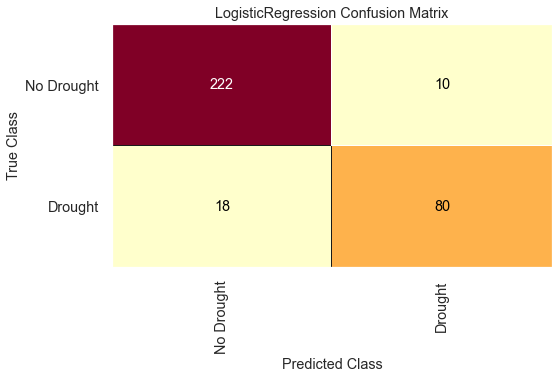

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [210]:
# Import the ConfusionMatrix visualizer
from yellowbrick.classifier import ConfusionMatrix

# fit model no training data
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions2 = [round(value) for value in y_pred]
# Create the confusion matrix visualizer
visualizer = ConfusionMatrix(model, classes=['No Drought', 'Drought'])

# Fit the visualizer and display the confusion matrix
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [211]:
# fit model no training data
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model1 = XGBClassifier()
model1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [212]:
print(model1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [213]:
from sklearn.metrics import confusion_matrix

# fit model no training data
from numpy import loadtxt
from yellowbrick.classifier import ConfusionMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model1 = XGBClassifier()
model1.fit(X_train, y_train)

# make predictions for test data
y_pred = model1.predict(X_test)
predictions1 = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# create confusion matrix
cm1 = confusion_matrix(y_test, predictions1)
print(cm1)



Accuracy: 99.39%
[[232   0]
 [  2  96]]


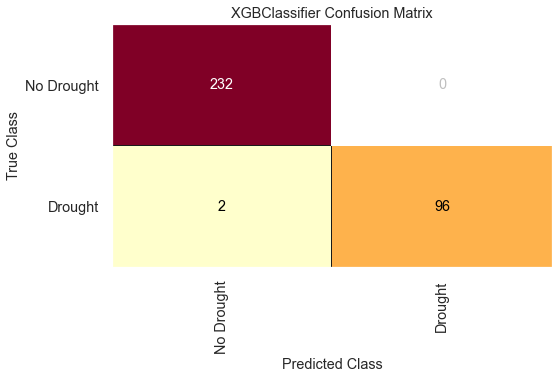

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [214]:
# Import the ConfusionMatrix visualizer
from yellowbrick.classifier import ConfusionMatrix

# fit model no training data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model on the training data
model1 = XGBClassifier()
model1.fit(X_train, y_train)

# make predictions for test data
y_pred1 = model1.predict(X_test)
predictions1 = [round(value) for value in y_pred1]
# Create the confusion matrix visualizer
visualizer = ConfusionMatrix(model1, classes=['No Drought', 'Drought'])

# Fit the visualizer and display the confusion matrix
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [215]:
from sklearn.neighbors import KNeighborsClassifier
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
predictions2 = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm2 = confusion_matrix(y_test, predictions2)
print(cm2)


Accuracy: 70.30%
[[232   0]
 [ 98   0]]


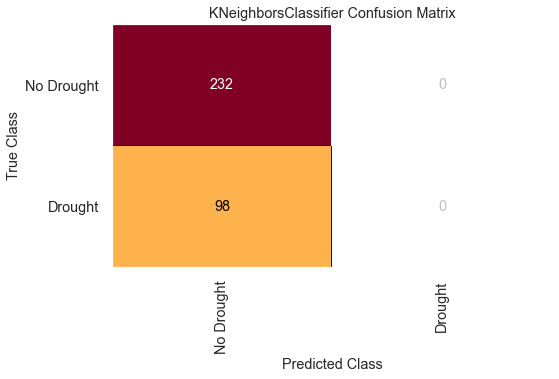

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [216]:
# Import the ConfusionMatrix visualizer
from yellowbrick.classifier import ConfusionMatrix

# fit model no training data
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model on the training data
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)

# make predictions for test data
y_pred2 = model2.predict(X_test)
predictions2 = [round(value) for value in y_pred2]
# Create the confusion matrix visualizer
visualizer1 = ConfusionMatrix(model2, classes=['No Drought', 'Drought'])

# Fit the visualizer and display the confusion matrix
visualizer1.fit(X_train, y_train)
visualizer1.score(X_test, y_test)
visualizer1.show()

In [217]:
from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
predictions3 = [round(value) for value in y_pred3]
accuracy = accuracy_score(y_test, predictions3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm3 = confusion_matrix(y_test, predictions3)
print(cm3)

Accuracy: 87.27%
[[190  42]
 [  0  98]]


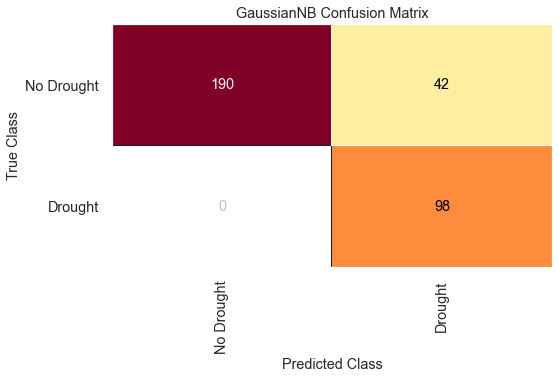

<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [218]:
visualizer2 = ConfusionMatrix(model3, classes=['No Drought', 'Drought'])

# Fit the visualizer and display the confusion matrix
visualizer2.fit(X_train, y_train)
visualizer2.score(X_test, y_test)
visualizer2.show()